# 로컬 개발 코드
- 로컬에서 주피터 노트북(Jupyter Notebook), 주피터 랩(JupyterLab) 또는 파이썬(Python)을 이용한다. 
- 사이킷 런(scikit-learn), 텐서플로우(tensorflow), 파이토치(pytorch)를 사용하여 딥러닝 프로그램을 개발한다.
- 파일명: 0_local_image_classification.ipynb

### 로컬 개발 워크플로우(workflow)  
- 로컬 개발 워크플로우를 다음의 4단계로 분리한다.

1. 데이터셋 준비(Data Setup)
- 로컬 저장소에서 전처리 및 학습에 필요한 학습 데이터셋을 준비한다.

2. 데이터 전처리(Data Preprocessing)
- 데이터셋의 분석 및 정규화(Normalization)등의 전처리를 수행한다.
- 데이터를 모델 학습에 사용할 수 있도록 가공한다.
- 추론과정에서 필요한 경우, 데이터 전처리에 사용된 객체를 meta_data 폴더 아래에 저장한다.

3. 학습 모델 훈련(Train Model)
- 데이터를 훈련에 사용할 수 있도록 가공한 뒤에 학습 모델을 구성한다. 
- 학습 모델을 준비된 데이터셋으로 훈련시킨다.
- 정확도(Accuracy)나 손실(Loss)등 학습 모델의 성능을 검증한다.
- 학습 모델의 성능 검증 후, 학습 모델을 배포한다.
- 배포할 학습 모델을 meta_data 폴더 아래에 저장한다.

4. 추론(Inference)
- 저장된 전처리 객체나 학습 모델 객체를 준비한다.
- 추론에 필요한 테스트 데이터셋을 준비한다.
- 배포된 학습 모델을 통해 테스트 데이터에 대한 추론을 진행한다. 

# 이미지 분류 (Image Classification)
- 지금부터 이미지 데이터를 이용하여 분류 (classification)을 진행해보고자 한다.

## 내가 그린 기린 그림은

### 사용할 데이터

![image](https://user-images.githubusercontent.com/84768279/153754287-1e970cc3-073b-49af-a2be-e4c3677773c3.png)

- Google에서 제공하는 Open Dataset인 [quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset) 이라는 낙서 이미지 데이터셋으로, 총 345개의 카테고리의 낙서들이 존재한다. 우리는 이 중에서 다음의 **10개**의 카테고리의 이미지 데이터들만 사용하고자 한다.
- 해당 데이터셋은 단순한 이미지 형태의 데이터셋이 아닌 numpy 형태의 파일들로 이루어져있다.
- 이미지 데이터셋이 어떻게 numpy 형태로 되어있는 것인지 확인하고 이해한다.

### 사용할 10개의 낙서 카테고리
- ant (개미)
- apple (사과)
- bus (버스)
- butterfly (나비)
- cup (컵)
- envelope (봉투)
- fish (물고기)
- giraffe (기린)
- lightbulb (전구)
- pig (돼지)

In [1]:
# Imports
import zipfile
import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers

## **1. 데이터셋 준비(Data Setup)**

In [2]:
# dataset.zip 파일 압축 풀기
zip_source_path = './dataset.zip'
zip_target_path = './meta_data'

extract_zip_file = zipfile.ZipFile(zip_source_path)
extract_zip_file.extractall(zip_target_path)
 
extract_zip_file.close()

In [3]:
my_path = './meta_data/dataset/'

# 카테고리
dataset=['ant','apple', 'bus', 'butterfly', 'cup', 'envelope','fish', 'giraffe', 'lightbulb','pig']
dataset_num= len(dataset) #10

# 경로에 있는 numpy를 load하고 dataset_numpy list에 추가한다. 
dataset_numpy = []
for i in range (dataset_num):
    ad = my_path + str(dataset[i]) +'.npy'
    dataset_numpy.append(np.load(ad))

각 카테고리의 이미지 수와 이미지의 크기를 확인해보자. 
- 각 카테고리 => 각 numpy 파일
- 각 numpy 파일의 shape => (이미지 수, 이미지의 크기)

확인해보면, 각 파일(카테고리) 별로 이미지의 수는 다르지만, 각 이미지의 크기는 같음을 알 수 있다. 여기서 784는 numpy array의 크기를 말하는데, 28*28=784로, **28 * 28**  크기의 이미지이기 때문에 총 **784**개의 값을 각 이미지가 가지게 된다.

In [4]:
print("( 이미지 수 , 이미지의 크기)")
for i in range (dataset_num):
    print(dataset_numpy[i].shape)

( 이미지 수 , 이미지의 크기)
(124612, 784)
(144722, 784)
(166208, 784)
(117999, 784)
(130721, 784)
(134863, 784)
(134150, 784)
(127182, 784)
(120879, 784)
(186770, 784)


그런데 어떻게 numpy 파일이 이미지가 될 수 있을까?

- 간단하게 말하자면, 28 * 28 크기의 이미지는 총 784개의 픽셀로 이루어져있는데, 각 픽셀의 색을 0~255의 값으로 표현할 수 있다. 그리고 그 값들을 하나의 배열로 표현한다면, numpy array가 되는 것이다. 

- 이해를 위해 아래를 보자. 아래는 Envelope(봉투) numpy 파일의 첫번째 값이다. 해당 array 값을 가로, 세로 각 각 28개씩 print할 경우, 0은 배경, 그 외의 값들은 선의 형태를 보임을 알 수 있다. 

In [5]:
np.set_printoptions(linewidth=116)
print(dataset_numpy[5][0])  # dataset_numpy[5] 가 envelope numpy 이다. 그중 0번째 array 값을 print 했다.

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0  11  17  26  34  34  37  51  51  51  66 112 123   1   0
   0   0   0   0   0   0   1  29  63  97 132 166 200 235 255 255 255 255 255 255 255 255 255 255 255 255 117   0
   0  12  78 138 180 215 248 255 255 255 247 213 179 145 110 102 102  85  85  85  74  68  68  69 215 255 101   0
   0 122 255 249 199 164 130  96  61  27   1   0   0   0   0   0   0   0   0   0   0   0   1 164

### 배열을 이미지로 시각화

앞에서 확인한 배열의 값을 더 잘 시각화 해보고자 한다. 각 카테고리 별로 5개의 이미지를 시각화 해보자.

In [6]:
def plot_samples(input_array, rows=1, cols=5, title=''):
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i].reshape((28,28)), cmap='gray_r')
        plt.xticks([])
        plt.yticks([])

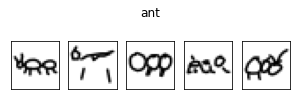

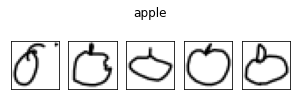

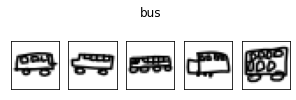

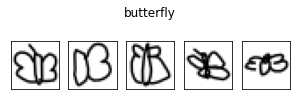

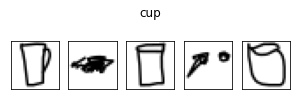

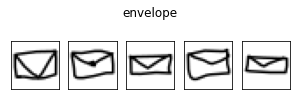

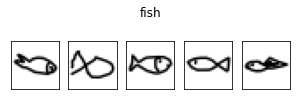

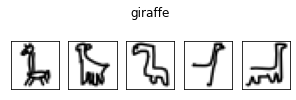

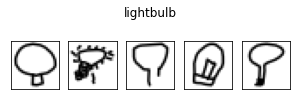

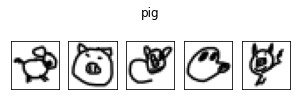

In [7]:
for i in range (dataset_num):
    plot_samples(dataset_numpy[i], title=dataset[i]+'\n')

## 2. 데이터 전처리 (Data Preprocessing)

### 데이터 준비 (Preparing Data)

앞서 확인하고 분석한 numpy array들을 훈련에 사용할 수 있는 형태로 바꾸고자 한다.

- 데이터 정규화 (Normalization)
  - 지금의 numpy 배열은 전부 0 ~ 255의 값을 가진다. 해당 값들을 전부 255로 나누어 0 ~ 1의 값을 가지도록 해준다.
- 데이터 합치기 & 레이블 생성
  - 지금 총 10개의 numpy array가 *dataset_numpy* list의 요소들로 존재한다. 이를 하나의 numpy array로 합쳐준다. (`concatenate`)
  - numpy array는 입력 데이터(X)이다. 하지만 훈련을 위해서는 입력 데이터 뿐만 아니라 정답 데이터(Y), 즉 레이블 (label)이 존재해야한다. 레이블 array를 생성해준다. 레이블은 앞서 정의했던 *dataset* array의 값의 index로 한다.
    - `dataset=['ant','apple', 'bus', 'butterfly', 'cup', 'envelope','fish', 'giraffe', 'lightbulb','pig']`
- 훈련 (train) & 평가 (test) 데이터셋 생성
  - 전체 데이터 중 일부는 훈련 (train)에 사용하고, 나머지 일부는 훈련된 모델의 성능을 평가 (test)하기 위해 사용하고자 한다. (`train_test_split`)
- 모델 훈련에 사용할 수 있는 형태로 변경
  - 입력 데이터 X는 numpy 배열의 차원을 바꿔준다. (`reshape`)
  - 정답(레이블) 데이터 Y는 one-hot-encoding을 수행한다.
    - One-hot-encoding: 0과 1로 데이터를 구별하는 인코딩이다. 
    - 본래 정답 데이터는 총 카테고리의 값이 10가지가 존재하므로 0에서 9의 숫자로 이루어져있다. 이를 one-hot-encoding으로 표현하면, 2의 label을 가지는 'bus'의 경우에 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]의 형태로 인코딩된다.
    - Keras에서 one-hot-encoding 함수를 지원한다. (`to_categorical`)

In [8]:
#각 카테고리별로 존재하는 이미지의 수가 다르다. 
#카테고리별로 같은 수의 이미지를 훈련시키기 위해 훈련시키고자 하는 이미지의 개수를 정해준다.
idx = 1000

#### 데이터 정규화 (Normalization) & 데이터 합치기 & 레이블 생성

In [9]:
# X: 입력 이미지 배열 데이터
# Y: 정답 레이블 데이터
X = (dataset_numpy[0][:idx,:]/255.) #첫번째 카테고리의 numpy array 정규화
Y = np.full(idx,0) #첫번째 카테고리의 정답 레이블 생성

# 첫번째 카테고리와 같은 방식으로 정규화 및 정답 레이블 생성
# 정규화된 입력 데이터와 새로 만든 정답 레이블 데이터를 각각 하나의 입력 데이터 배열, 정답 데이터 배열로 만들어준다..
for i in range (1,dataset_num):
    X = np.concatenate((X,dataset_numpy[i][:idx,:]/255.), axis=0).astype('float32')
    Y = np.concatenate((Y,np.full(idx,i)), axis=0).astype('float32')

##### 훈련 & 평가 데이터셋 생성

전체 데이터셋 중 **8:2**의 비율로 훈련:평가 데이터셋을 생성한다.

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

##### 모델 훈련에 사용할 수 있는 형태로 변경

In [11]:
# X의 값을 [samples][pixels][width][height] 형태로 reshape한다.
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28 , 1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28 , 1).astype('float32')

In [12]:
# reshape된 결과 확인 및 원래 배열의 형태와 비교한다.
print("X_train: "+str(X_train.shape))
print("X_train_cnn: "+str(X_train_cnn.shape))

X_train: (8000, 784)
X_train_cnn: (8000, 28, 28, 1)


In [13]:
# Y의 배열에 one-hot-encoding 진행
Y_train_cnn = np_utils.to_categorical(Y_train)
Y_test_cnn = np_utils.to_categorical(Y_test)
num_classes = Y_test_cnn.shape[1] # class는 총 10개이다.

In [14]:
# encoding된 결과 확인 및 원래 배열의 형태와 비교
print("Y_train: "+str(Y_train.shape))
print("Y_train_cnn: "+str(Y_train_cnn.shape))
print("class 개수: "+str(num_classes))

Y_train: (8000,)
Y_train_cnn: (8000, 10)
class 개수: 10


## **3. 학습 모델 훈련 (Train Model)**

이미지 분류를 위해 아주 간단한 CNN 모델을 Keras를 이용하여 구축하고자 한다.

In [15]:
#모델 구축
model = keras.Sequential(
    [
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"),
        layers.Dropout(0.25),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.25),
        layers.Dense(num_classes, activation="softmax")
    ]
)

model.summary() #모델층 (layer) 정보 확인

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                        

### 모델 컴파일 및 학습 (Compile and Train Model)

- 모델 컴파일 (Compile Model)
  - Keras의 compile 함수를 통해 모델의 optimizer, loss, 그리고 metrics를 선택할 수 있다.
  - Loss: categoriacal_crossentropy
    - 우리는 레이블로 one-hot-encoding을 사용했으므로 loss로 'categorical_crossentropy'를 사용한다.
- 모델 학습 (Train Model)
  - 앞서 구축한 모델을 준비해준 입력 데이터와 레이블 데이터로 학습시킨다.

##### 모델 컴파일 (Compile Model)

In [16]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

##### 모델 학습 (Train Model)

In [17]:
batch_size = 50
epochs = 20

model.fit(X_train_cnn, Y_train_cnn, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/20
128/128 [==============================] - 8s 12ms/step - loss: 1.2658 - accuracy: 0.5903 - val_loss: 0.6452 - val_accuracy: 0.8094
Epoch 2/20
128/128 [==============================] - 1s 10ms/step - loss: 0.7228 - accuracy: 0.7748 - val_loss: 0.4660 - val_accuracy: 0.8650
Epoch 3/20
128/128 [==============================] - 1s 9ms/step - loss: 0.5251 - accuracy: 0.8342 - val_loss: 0.3743 - val_accuracy: 0.8950
Epoch 4/20
128/128 [==============================] - 1s 10ms/step - loss: 0.4513 - accuracy: 0.8534 - val_loss: 0.3859 - val_accuracy: 0.8838
Epoch 5/20
128/128 [==============================] - 1s 9ms/step - loss: 0.3681 - accuracy: 0.8795 - val_loss: 0.4062 - val_accuracy: 0.8813
Epoch 6/20
128/128 [==============================] - 1s 11ms/step - loss: 0.3222 - accuracy: 0.8905 - val_loss: 0.3650 - val_accuracy: 0.8981
Epoch 7/20
128/128 [==============================] - 1s 10ms/step - loss: 0.2762 - accuracy: 0.9047 - val_loss: 0.3816 - val_accuracy: 0.8906
E

### 모델 평가 (Evaluate Model)

In [18]:
loss, acc = model.evaluate(X_test_cnn, Y_test_cnn, verbose=0)

In [19]:
print("loss:" + str(loss)+ " accuracy: " + str(acc))

loss:0.6104413866996765 accuracy: 0.8855000138282776


## **4. 추론 (Inference)**

훈련시킨 모델을 직접 사용해보고자 한다. 잘 훈련된 모델이라면 우리가 직접 그린 낙서를 입력 데이터로 주었을 때, 그 낙서의 카테고리를 결과값으로 모델이 내보낼 것이다. 그 과정을 진행해보고자 한다.

- 이미지 생성
- 이미지를 모델의 입력 데이터 형태로 변환
- 결과 확인

##### 이미지 생성
예제에서는 미리 준비해둔 이미지 파일을 대신 받아 추론을 진행해보고자 한다.

실제 사용자가 자신의 이미지를 만들어 실행해볼 수도 있다.

- 이미지 생성법
  1. 그림판 - 파일 - 이미지 속성 에서 너비(W)/높이(H)의 값을 각각 28로 설정한다. 
  2. 28 * 28 크기의 캔버스에 도구 - 연필 (1px) 을 이용하여 카테고리에 맞는 그림을 그린다. 카테고리로는 다음과 같은 것들이 있다.
    - ant (개미)
    - apple (사과)
    - bus (버스)
    - butterfly (나비)
    - cup (컵)
    - envelope (봉투)
    - fish (물고기)
    - giraffe (기린)
    - lightbulb (전구)
    - pig (돼지)

In [20]:
# dataset.zip 파일을 dataset 폴더에 압축을 풀어준다.
zip_source_path = './test_dataset.zip'
zip_target_path = './meta_data'

extract_zip_file = zipfile.ZipFile(zip_source_path)
extract_zip_file.extractall(zip_target_path)
 
extract_zip_file.close()

##### 이미지를 모델의 입력 데이터 형태로 변환
- 이미지 데이터를 읽어온다.
- numpy array 형태로 변형시켜준 뒤, 정규화를 실시한다.

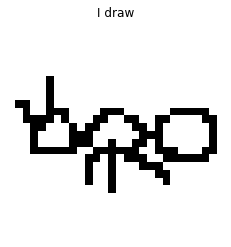

In [21]:
my_path='./meta_data/test_dataset/'

image_name = 'my_ant.png'
img = cv2.imread(my_path + image_name, cv2.IMREAD_GRAYSCALE)
ret , binary = cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
my_image = np.asarray(cv2.resize(binary, dsize=(28, 28), interpolation=cv2.INTER_AREA))/255

#입력 이미지 확인
plt.axis('off')
plt.title('I draw')
plt.imshow(my_image, cmap='gray_r')

##### 결과 확인

입력 데이터를 모델에 넣었을 때, 결과값이 하나의 숫자로 나오는 것이 아닌 총 10개의 카테고리에 대한 신뢰도 (confidence)를 전부 보여준다. 우리는 이 중에서 가장 큰 신뢰도를 보이는 레이블, 즉 모델이 가장 정답으로 확신하는 답을 print해서 보여주고자 한다.

In [22]:
# 모델 입력 데이터로 사용하기 위해 reshape 
input_image_data = (my_image.reshape(-1, 28, 28, 1))

# 추론
predict_result = model.predict(input_image_data)

#결과 확인
# np.argmax는 배열 중 가장 큰 값의 인덱스를 반환해준다.
print(dataset[np.argmax(predict_result[0])])

1/1 [==============================] - 0s 172ms/step
ant


다른 이미지들에 대해서도 확인해보자.

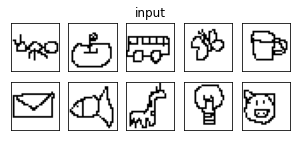

In [23]:
image_name = 'my_ant.png'
img = cv2.imread(my_path + image_name, cv2.IMREAD_GRAYSCALE)
ret , binary = cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
my_image = np.asarray(cv2.resize(binary, dsize=(28, 28), interpolation=cv2.INTER_AREA)).reshape(-1,784)

for i in range (1, len(dataset)):
    image_name = 'my_' + str(dataset[i]) + '.png'
    img = cv2.imread(my_path + image_name, cv2.IMREAD_GRAYSCALE)
    ret , binary = cv2.threshold(img,200,255,cv2.THRESH_BINARY_INV)
    my_image_2 = np.asarray(cv2.resize(binary, dsize=(28,28), interpolation=cv2.INTER_AREA)).reshape(-1,784)
    my_image = np.concatenate((my_image, my_image_2), axis = 0)

plot_samples(my_image, rows = 2, cols = 5, title = 'input')

In [24]:
# 모델 입력 데이터로 사용하기 위해 reshape 
my_image_norm = (my_image/255).astype('float32')
input_image_data = (my_image_norm.reshape(my_image_norm.shape[0], 28, 28, 1))

# 추론
predict_result = model.predict(input_image_data)

#결과 확인
# np.argmax는 배열 중 가장 큰 값의 인덱스를 반환해준다.
print('\t\t\tLABELS :', dataset)
for i in range (len(predict_result)):
    print('prediction :', dataset[np.argmax(predict_result[i])], end='\t')
    print('possibility :', [f'{result:.3f}' for result in predict_result[i].tolist()])

1/1 [==============================] - 0s 60ms/step
			LABELS : ['ant', 'apple', 'bus', 'butterfly', 'cup', 'envelope', 'fish', 'giraffe', 'lightbulb', 'pig']
prediction : ant	possibility : ['1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
prediction : apple	possibility : ['0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
prediction : bus	possibility : ['0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
prediction : butterfly	possibility : ['0.003', '0.000', '0.000', '0.997', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
prediction : cup	possibility : ['0.000', '0.000', '0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000', '0.000']
prediction : envelope	possibility : ['0.000', '0.000', '0.000', '0.000', '0.000', '1.000', '0.000', '0.000', '0.000', '0.000']
prediction : fish	possibility : ['0.062', '0.004', '0.000', '0.189', '0.000', '0.001', '0.737', 